In [38]:
import numpy as np;
import pandas as pd;
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import matthews_corrcoef,make_scorer,roc_auc_score,precision_recall_curve, auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
!pip install --upgrade scikit-learn
roc_auc_scoreScorer=make_scorer(roc_auc_score)
mccScorer = make_scorer(matthews_corrcoef)
from numpy import mean
from numpy import std

from google.colab import drive
drive.mount("/content/gdrive")

# ANOVA feature selection for numeric input and categorical output
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import discriminant_analysis

from sklearn.preprocessing import StandardScaler

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#read training dataset 1
data1 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset_1_Training.csv')

X_train_actual_1=data1[:-2].T[1:].values

y_train_actual_1 = data1[-2:].T[-130:].T.values


In [3]:
#read training dataset 2
data2 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset_2_Training.csv')

X_train_actual_2=data2[:-4].T[1:].values

y_train_actual_2 = data2[-4:].T[-340:].T.values


In [4]:
co1={'X':X_train_actual_1,'Y': y_train_actual_1[0]};
co2={'X':X_train_actual_1,'Y': y_train_actual_1[1]};

co3={'X':X_train_actual_2,'Y': y_train_actual_2[0]};
co4={'X':X_train_actual_2,'Y': y_train_actual_2[1]};
co5={'X':X_train_actual_2,'Y': y_train_actual_2[2]};
co6={'X':X_train_actual_2,'Y': y_train_actual_2[3]};

In [5]:
def determine_number_of_top_features(X,Y):
  X=pd.DataFrame(X)
  X=X.astype(float)

  Y=pd.DataFrame(Y)
  Y=Y.astype(int)

  sel = f_classif(X, Y)
  p_values = pd.Series(sel[1])
  p_values.index = X.columns
  p_values.sort_values(ascending=True, inplace=True)
  p_values = p_values[p_values < 0.05]
  X_p = X[p_values.index]
  return X_p.shape[1]

In [6]:
best_co1=determine_number_of_top_features(**co1)
best_co2=determine_number_of_top_features(**co2)
best_co3=determine_number_of_top_features(**co3)
best_co4=determine_number_of_top_features(**co4)
best_co5=determine_number_of_top_features(**co5)
best_co6=determine_number_of_top_features(**co6)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [7]:
def feature_selector(X,Y,numberOfFeaturesToBeSelected=1):
  if(numberOfFeaturesToBeSelected == 1):
    totalNumberOfFeatures=X.shape[1]
    numberOfFeaturesToBeSelected=totalNumberOfFeatures//2;
  # define feature selection
  fs = SelectKBest(score_func=f_classif, k=numberOfFeaturesToBeSelected)
  # apply feature selection
  return fs

In [ ]:
def stackingClassifier_with_TT_split(X,Y,numberOfFeatures=1):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

  X_train_scaled = standardScaler(X_train)
  
  # define the base models
  level0 = list()
  level0.append(('lr', LogisticRegression()))
  # level0.append(('knn', KNeighborsClassifier()))
  # level0.append(('gd', GradientBoostingClassifier()))
  level0.append(('ada', AdaBoostClassifier()))
  level0.append(('rf', RandomForestClassifier(n_estimators=800)))
  level0.append(('bayes', GaussianNB()))
  # define meta learner model
  level1 = LogisticRegression()
  # define the stacking ensemble
  model = StackingClassifier(estimators=level0, final_estimator=level1)

  fs_model = feature_selector(X_train_scaled,y_train,numberOfFeaturesToBeSelected=numberOfFeatures);
  X_selected_features = fs_model.fit(X_train_scaled,y_train).transform(X_train_scaled);

  model.fit(X_selected_features,y_train.astype('int'))
  
  y_trainhat = model.predict(X_selected_features)
  # make predictions
  X_test_scaled = standardScaler(X_test)
  X_test_selected_features = fs_model.transform(X_test_scaled);
  y_testhat = model.predict(X_test_selected_features)
  
  # summarize result
  print(model.get_params())
  print("Training")
  mcc = matthews_corrcoef(y_train.astype('int'), y_trainhat.astype('int'))
  print('MCC: %.3f' % mcc)
  print("Testing")
  mcc = matthews_corrcoef(y_test.astype('int'), y_testhat.astype('int'))
  print('MCC: %.3f' % mcc)
  return model


In [ ]:
def standardScaler(X):
  scaler = StandardScaler()
  return scaler.fit_transform(X.astype(np.float32))

In [8]:
def plot_PRC_for_CV(predictor,k_fold,X,y,label):
  f, axes = plt.subplots(1,1,squeeze=False)
  
  y_real = []
  y_proba = []
  
  for i, (train_index, test_index) in enumerate(k_fold.split(X,y)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision, recall, _ = precision_recall_curve(ytest, pred_proba[:,1])
    lab = 'Fold %d AUC=%.4f' % (i+1, auc(recall, precision))
    axes[0,0].step(recall, precision, label=lab)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])

  y_real = np.concatenate(y_real)
  y_proba = np.concatenate(y_proba)
  precision, recall, _ = precision_recall_curve(y_real, y_proba)
  lab = 'Overall AUC=%.4f' % (auc(recall, precision))
  axes[0,0].step(recall, precision, label=lab, lw=2, color='black')
  axes[0,0].set_xlabel('Recall')
  axes[0,0].set_ylabel('Precision')
  axes[0,0].legend(loc='lower left', fontsize='small')
  axes[0,0].set(title=label)

  # f.tight_layout()
  f.savefig(label+'.png')

In [9]:
def plot_ROC_for_CV(classifier,cv,X,y,label):
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  fig, ax = plt.subplots()
  for i, (train, test) in enumerate(cv.split(X, y)):
      classifier.fit(X[train], y[train])
      viz = RocCurveDisplay.from_estimator(
          classifier,
          X[test],
          y[test],
          name="ROC fold {}".format(i),
          alpha=0.3,
          lw=1,
          ax=ax,
      )
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="b",
      label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
      lw=2,
      alpha=0.8,
  )

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(
      mean_fpr,
      tprs_lower,
      tprs_upper,
      color="grey",
      alpha=0.2,
      label=r"$\pm$ 1 std. dev.",
  )

  ax.set(
      xlim=[-0.05, 1.05],
      ylim=[-0.05, 1.05],
      title=label,
  )
  ax.legend(loc="lower right")
  plt.show()
  fig.savefig(label+'.png')

In [29]:
def stackingClassifier_with_cross_validation(X,Y,level0,endpointLabel,numberOfFeatures=1):
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X.astype(np.float32))
  

  # define meta learner model
  level1 = LogisticRegression()
  # define the stacking ensemble
  model = StackingClassifier(estimators=level0, final_estimator=level1)

  # model = BaggingClassifier(base_estimator=baseestimator,n_estimators=20,random_state=1)
  
  scoringReports={'mccScorer': mccScorer,'accuracy': 'accuracy','precision':'precision','recall':'recall', 'f1':'f1','ruc_auc':roc_auc_scoreScorer}
  
  # define evaluation
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

  fs_model = feature_selector(X_train_scaled,Y,numberOfFeaturesToBeSelected=numberOfFeatures);
  X_selected_features=fs_model.fit(X_train_scaled,Y).transform(X_train_scaled);
  scores = cross_validate(model,X_selected_features , Y.astype('int'), scoring=scoringReports, cv=cv)

  # summarize result
  print(model.get_params())
  print('MCC Score- Mean: %.3f SD: (%.3f)' % (mean(scores['test_mccScorer']), std(scores['test_mccScorer'])))
  print(list(scores.keys()))
  print("Means",mean(list(scores.values()),axis=1))
  print("SD",std(list(scores.values()),axis=1))
  plot_PRC_for_CV(model,cv,X_selected_features,Y.astype('int'),'PR-Stack-'+endpointLabel)
  plot_ROC_for_CV(model,cv,X_selected_features,Y.astype('int'),'ROC-Stack-'+endpointLabel)
  return model


{'cv': None, 'estimators': [('lr', LogisticRegression(class_weight='balanced')), ('lda', LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'))], 'final_estimator__C': 1.0, 'final_estimator__class_weight': None, 'final_estimator__dual': False, 'final_estimator__fit_intercept': True, 'final_estimator__intercept_scaling': 1, 'final_estimator__l1_ratio': None, 'final_estimator__max_iter': 100, 'final_estimator__multi_class': 'auto', 'final_estimator__n_jobs': None, 'final_estimator__penalty': 'l2', 'final_estimator__random_state': None, 'final_estimator__solver': 'lbfgs', 'final_estimator__tol': 0.0001, 'final_estimator__verbose': 0, 'final_estimator__warm_start': False, 'final_estimator': LogisticRegression(), 'n_jobs': None, 'passthrough': False, 'stack_method': 'auto', 'verbose': 0, 'lr': LogisticRegression(class_weight='balanced'), 'lda': LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'), 'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__dual': False, 'lr__fit_interce

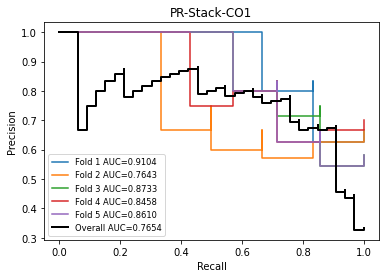

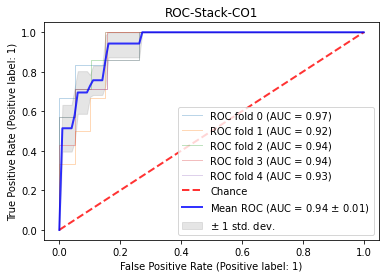

StackingClassifier(estimators=[('lr',
                                LogisticRegression(class_weight='balanced')),
                               ('lda',
                                LinearDiscriminantAnalysis(shrinkage='auto',
                                                           solver='lsqr'))],
                   final_estimator=LogisticRegression())

In [40]:
base_estimator=LogisticRegression(C=1e-05,penalty='none',solver='newton-cg',class_weight='balanced');
#base_estimator=LogisticRegression(class_weight='balanced');

# define the base models
level0 = list()
level0.append(('lr',LogisticRegression(class_weight='balanced') ))
level0.append(('lda',discriminant_analysis.LinearDiscriminantAnalysis(shrinkage= 'auto', solver= 'lsqr') ))
# level0.append(('knn', KNeighborsClassifier()))
# level0.append(('gd', GradientBoostingClassifier()))
# level0.append(('ada', AdaBoostClassifier(base_estimator=base_estimator,learning_rate=0.1,n_estimators=50)))
# level0.append(('rf', RandomForestClassifier(class_weight='balanced',n_estimators=500,random_state=1)))
# level0.append(('bayes', GaussianNB()))

stackingClassifier_with_cross_validation(co1['X'],co1['Y'],level0,'CO1',best_co1)

{'cv': None, 'estimators': [('lda', LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')), ('bayes', GaussianNB())], 'final_estimator__C': 1.0, 'final_estimator__class_weight': None, 'final_estimator__dual': False, 'final_estimator__fit_intercept': True, 'final_estimator__intercept_scaling': 1, 'final_estimator__l1_ratio': None, 'final_estimator__max_iter': 100, 'final_estimator__multi_class': 'auto', 'final_estimator__n_jobs': None, 'final_estimator__penalty': 'l2', 'final_estimator__random_state': None, 'final_estimator__solver': 'lbfgs', 'final_estimator__tol': 0.0001, 'final_estimator__verbose': 0, 'final_estimator__warm_start': False, 'final_estimator': LogisticRegression(), 'n_jobs': None, 'passthrough': False, 'stack_method': 'auto', 'verbose': 0, 'lda': LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'), 'bayes': GaussianNB(), 'lda__covariance_estimator': None, 'lda__n_components': None, 'lda__priors': None, 'lda__shrinkage': 'auto', 'lda__solver': 'lsqr', 'lda_

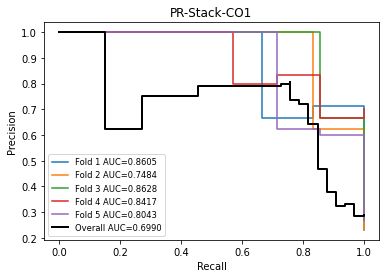

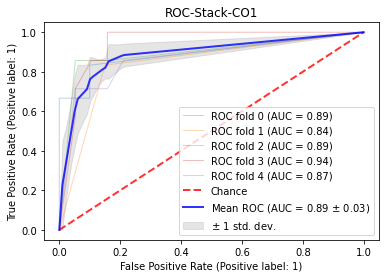

StackingClassifier(estimators=[('lda',
                                LinearDiscriminantAnalysis(shrinkage='auto',
                                                           solver='lsqr')),
                               ('bayes', GaussianNB())],
                   final_estimator=LogisticRegression())

In [45]:
base_estimator=LogisticRegression(C=1e-05,penalty='none',solver='newton-cg',class_weight='balanced');
#base_estimator=LogisticRegression(class_weight='balanced');

# define the base models
level0 = list()
# level0.append(('lr',LogisticRegression(class_weight='balanced') ))
level0.append(('lda',discriminant_analysis.LinearDiscriminantAnalysis(shrinkage= 'auto', solver= 'lsqr') ))
# level0.append(('knn', KNeighborsClassifier()))
# level0.append(('gd', GradientBoostingClassifier()))
# level0.append(('ada', AdaBoostClassifier(base_estimator=base_estimator,learning_rate=0.1,n_estimators=50)))
# level0.append(('rf', RandomForestClassifier(class_weight='balanced',n_estimators=500,random_state=1)))
level0.append(('bayes', GaussianNB()))

stackingClassifier_with_cross_validation(co1['X'],co1['Y'],level0,'CO1',best_co1)

{'cv': None, 'estimators': [('lr', LogisticRegression(class_weight='balanced')), ('ada', AdaBoostClassifier()), ('bayes', GaussianNB())], 'final_estimator__C': 1.0, 'final_estimator__class_weight': None, 'final_estimator__dual': False, 'final_estimator__fit_intercept': True, 'final_estimator__intercept_scaling': 1, 'final_estimator__l1_ratio': None, 'final_estimator__max_iter': 100, 'final_estimator__multi_class': 'auto', 'final_estimator__n_jobs': None, 'final_estimator__penalty': 'l2', 'final_estimator__random_state': None, 'final_estimator__solver': 'lbfgs', 'final_estimator__tol': 0.0001, 'final_estimator__verbose': 0, 'final_estimator__warm_start': False, 'final_estimator': LogisticRegression(), 'n_jobs': None, 'passthrough': False, 'stack_method': 'auto', 'verbose': 0, 'lr': LogisticRegression(class_weight='balanced'), 'ada': AdaBoostClassifier(), 'bayes': GaussianNB(), 'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__dual': False, 'lr__fit_intercept': True, 'lr__intercept_scal

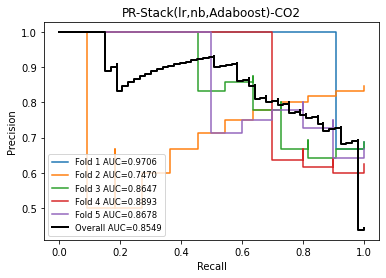

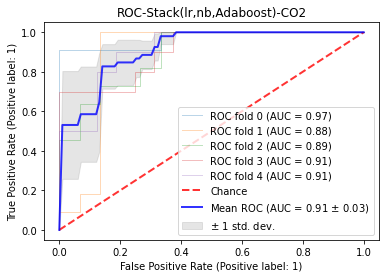

StackingClassifier(estimators=[('lr',
                                LogisticRegression(class_weight='balanced')),
                               ('ada', AdaBoostClassifier()),
                               ('bayes', GaussianNB())],
                   final_estimator=LogisticRegression())

In [24]:
stackingClassifier_with_cross_validation(co2['X'],co2['Y'],'CO2',best_co2)

{'cv': None, 'estimators': [('lr', LogisticRegression(class_weight='balanced')), ('ada', AdaBoostClassifier()), ('bayes', GaussianNB())], 'final_estimator__C': 1.0, 'final_estimator__class_weight': None, 'final_estimator__dual': False, 'final_estimator__fit_intercept': True, 'final_estimator__intercept_scaling': 1, 'final_estimator__l1_ratio': None, 'final_estimator__max_iter': 100, 'final_estimator__multi_class': 'auto', 'final_estimator__n_jobs': None, 'final_estimator__penalty': 'l2', 'final_estimator__random_state': None, 'final_estimator__solver': 'lbfgs', 'final_estimator__tol': 0.0001, 'final_estimator__verbose': 0, 'final_estimator__warm_start': False, 'final_estimator': LogisticRegression(), 'n_jobs': None, 'passthrough': False, 'stack_method': 'auto', 'verbose': 0, 'lr': LogisticRegression(class_weight='balanced'), 'ada': AdaBoostClassifier(), 'bayes': GaussianNB(), 'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__dual': False, 'lr__fit_intercept': True, 'lr__intercept_scal

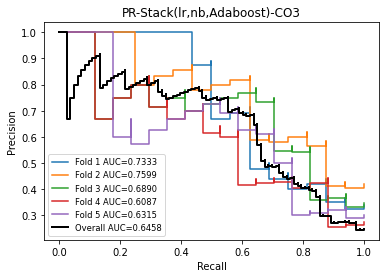

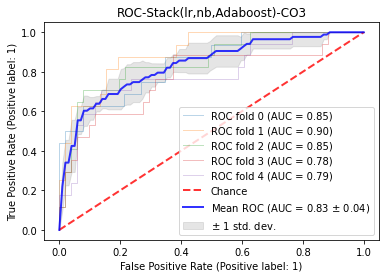

StackingClassifier(estimators=[('lr',
                                LogisticRegression(class_weight='balanced')),
                               ('ada', AdaBoostClassifier()),
                               ('bayes', GaussianNB())],
                   final_estimator=LogisticRegression())

In [25]:
stackingClassifier_with_cross_validation(co3['X'],co3['Y'],'CO3',best_co3)

{'cv': None, 'estimators': [('lr', LogisticRegression(class_weight='balanced')), ('ada', AdaBoostClassifier()), ('bayes', GaussianNB())], 'final_estimator__C': 1.0, 'final_estimator__class_weight': None, 'final_estimator__dual': False, 'final_estimator__fit_intercept': True, 'final_estimator__intercept_scaling': 1, 'final_estimator__l1_ratio': None, 'final_estimator__max_iter': 100, 'final_estimator__multi_class': 'auto', 'final_estimator__n_jobs': None, 'final_estimator__penalty': 'l2', 'final_estimator__random_state': None, 'final_estimator__solver': 'lbfgs', 'final_estimator__tol': 0.0001, 'final_estimator__verbose': 0, 'final_estimator__warm_start': False, 'final_estimator': LogisticRegression(), 'n_jobs': None, 'passthrough': False, 'stack_method': 'auto', 'verbose': 0, 'lr': LogisticRegression(class_weight='balanced'), 'ada': AdaBoostClassifier(), 'bayes': GaussianNB(), 'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__dual': False, 'lr__fit_intercept': True, 'lr__intercept_scal

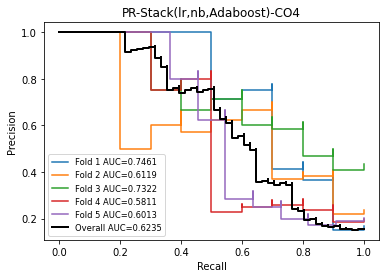

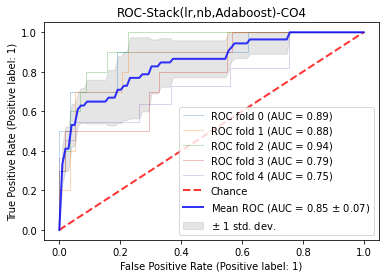

StackingClassifier(estimators=[('lr',
                                LogisticRegression(class_weight='balanced')),
                               ('ada', AdaBoostClassifier()),
                               ('bayes', GaussianNB())],
                   final_estimator=LogisticRegression())

In [26]:
stackingClassifier_with_cross_validation(co4['X'],co4['Y'],'CO4',best_co4)

{'cv': None, 'estimators': [('lr', LogisticRegression(class_weight='balanced')), ('ada', AdaBoostClassifier()), ('bayes', GaussianNB())], 'final_estimator__C': 1.0, 'final_estimator__class_weight': None, 'final_estimator__dual': False, 'final_estimator__fit_intercept': True, 'final_estimator__intercept_scaling': 1, 'final_estimator__l1_ratio': None, 'final_estimator__max_iter': 100, 'final_estimator__multi_class': 'auto', 'final_estimator__n_jobs': None, 'final_estimator__penalty': 'l2', 'final_estimator__random_state': None, 'final_estimator__solver': 'lbfgs', 'final_estimator__tol': 0.0001, 'final_estimator__verbose': 0, 'final_estimator__warm_start': False, 'final_estimator': LogisticRegression(), 'n_jobs': None, 'passthrough': False, 'stack_method': 'auto', 'verbose': 0, 'lr': LogisticRegression(class_weight='balanced'), 'ada': AdaBoostClassifier(), 'bayes': GaussianNB(), 'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__dual': False, 'lr__fit_intercept': True, 'lr__intercept_scal

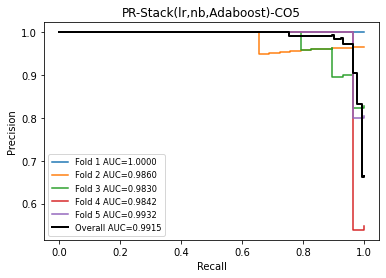

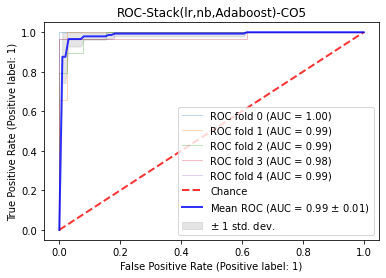

StackingClassifier(estimators=[('lr',
                                LogisticRegression(class_weight='balanced')),
                               ('ada', AdaBoostClassifier()),
                               ('bayes', GaussianNB())],
                   final_estimator=LogisticRegression())

In [27]:
stackingClassifier_with_cross_validation(co5['X'],co5['Y'],'CO5',best_co5)

{'cv': None, 'estimators': [('lr', LogisticRegression(class_weight='balanced')), ('ada', AdaBoostClassifier(learning_rate=0.1))], 'final_estimator__C': 1.0, 'final_estimator__class_weight': None, 'final_estimator__dual': False, 'final_estimator__fit_intercept': True, 'final_estimator__intercept_scaling': 1, 'final_estimator__l1_ratio': None, 'final_estimator__max_iter': 100, 'final_estimator__multi_class': 'auto', 'final_estimator__n_jobs': None, 'final_estimator__penalty': 'l2', 'final_estimator__random_state': None, 'final_estimator__solver': 'lbfgs', 'final_estimator__tol': 0.0001, 'final_estimator__verbose': 0, 'final_estimator__warm_start': False, 'final_estimator': LogisticRegression(), 'n_jobs': None, 'passthrough': False, 'stack_method': 'auto', 'verbose': 0, 'lr': LogisticRegression(class_weight='balanced'), 'ada': AdaBoostClassifier(learning_rate=0.1), 'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__dual': False, 'lr__fit_intercept': True, 'lr__intercept_scaling': 1, 'lr__

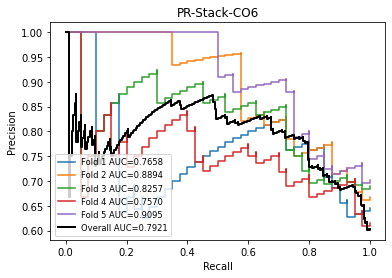

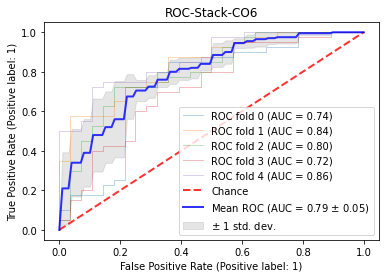

StackingClassifier(estimators=[('lr',
                                LogisticRegression(class_weight='balanced')),
                               ('ada', AdaBoostClassifier(learning_rate=0.1))],
                   final_estimator=LogisticRegression())

In [41]:
# define the base models
level0 = list()
level0.append(('lr',LogisticRegression(class_weight='balanced') ))
# level0.append(('knn', KNeighborsClassifier()))
# level0.append(('gd', GradientBoostingClassifier()))
level0.append(('ada', AdaBoostClassifier(learning_rate=0.1,n_estimators=50)))
# level0.append(('rf', RandomForestClassifier(class_weight='balanced',n_estimators=500,random_state=1)))
# level0.append(('bayes', GaussianNB()))

stackingClassifier_with_cross_validation(co6['X'],co6['Y'],level0,'CO6')

{'cv': None, 'estimators': [('lr', LogisticRegression(class_weight='balanced')), ('ada', AdaBoostClassifier(learning_rate=0.1))], 'final_estimator__C': 1.0, 'final_estimator__class_weight': None, 'final_estimator__dual': False, 'final_estimator__fit_intercept': True, 'final_estimator__intercept_scaling': 1, 'final_estimator__l1_ratio': None, 'final_estimator__max_iter': 100, 'final_estimator__multi_class': 'auto', 'final_estimator__n_jobs': None, 'final_estimator__penalty': 'l2', 'final_estimator__random_state': None, 'final_estimator__solver': 'lbfgs', 'final_estimator__tol': 0.0001, 'final_estimator__verbose': 0, 'final_estimator__warm_start': False, 'final_estimator': LogisticRegression(), 'n_jobs': None, 'passthrough': False, 'stack_method': 'auto', 'verbose': 0, 'lr': LogisticRegression(class_weight='balanced'), 'ada': AdaBoostClassifier(learning_rate=0.1), 'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__dual': False, 'lr__fit_intercept': True, 'lr__intercept_scaling': 1, 'lr__

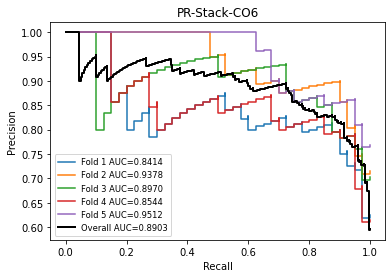

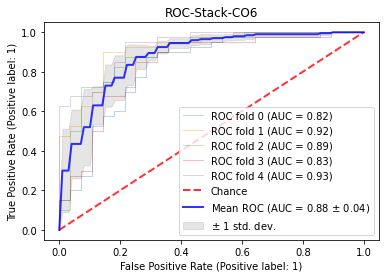

StackingClassifier(estimators=[('lr',
                                LogisticRegression(class_weight='balanced')),
                               ('ada', AdaBoostClassifier(learning_rate=0.1))],
                   final_estimator=LogisticRegression())

In [42]:
# define the base models
level0 = list()
level0.append(('lr',LogisticRegression(class_weight='balanced') ))
# level0.append(('knn', KNeighborsClassifier()))
# level0.append(('gd', GradientBoostingClassifier()))
level0.append(('ada', AdaBoostClassifier(learning_rate=0.1,n_estimators=50)))
# level0.append(('rf', RandomForestClassifier(class_weight='balanced',n_estimators=500,random_state=1)))
# level0.append(('bayes', GaussianNB()))

stackingClassifier_with_cross_validation(co6['X'],co6['Y'],level0,'CO6',best_co6)

{'cv': None, 'estimators': [('lr', LogisticRegression(class_weight='balanced')), ('ada', AdaBoostClassifier(learning_rate=0.1)), ('bayes', GaussianNB())], 'final_estimator__C': 1.0, 'final_estimator__class_weight': None, 'final_estimator__dual': False, 'final_estimator__fit_intercept': True, 'final_estimator__intercept_scaling': 1, 'final_estimator__l1_ratio': None, 'final_estimator__max_iter': 100, 'final_estimator__multi_class': 'auto', 'final_estimator__n_jobs': None, 'final_estimator__penalty': 'l2', 'final_estimator__random_state': None, 'final_estimator__solver': 'lbfgs', 'final_estimator__tol': 0.0001, 'final_estimator__verbose': 0, 'final_estimator__warm_start': False, 'final_estimator': LogisticRegression(), 'n_jobs': None, 'passthrough': False, 'stack_method': 'auto', 'verbose': 0, 'lr': LogisticRegression(class_weight='balanced'), 'ada': AdaBoostClassifier(learning_rate=0.1), 'bayes': GaussianNB(), 'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__dual': False, 'lr__fit_int

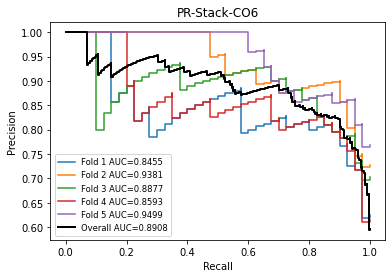

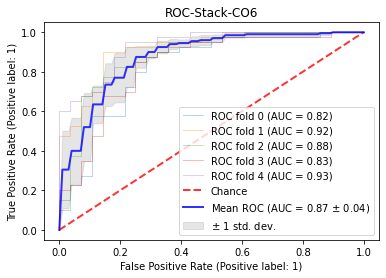

StackingClassifier(estimators=[('lr',
                                LogisticRegression(class_weight='balanced')),
                               ('ada', AdaBoostClassifier(learning_rate=0.1)),
                               ('bayes', GaussianNB())],
                   final_estimator=LogisticRegression())

In [43]:
# define the base models
level0 = list()
level0.append(('lr',LogisticRegression(class_weight='balanced') ))
# level0.append(('knn', KNeighborsClassifier()))
# level0.append(('gd', GradientBoostingClassifier()))
level0.append(('ada', AdaBoostClassifier(learning_rate=0.1,n_estimators=50)))
# level0.append(('rf', RandomForestClassifier(class_weight='balanced',n_estimators=500,random_state=1)))
level0.append(('bayes', GaussianNB()))

stackingClassifier_with_cross_validation(co6['X'],co6['Y'],level0,'CO6',best_co6)

{'cv': None, 'estimators': [('lr', LogisticRegression(class_weight='balanced')), ('ada', AdaBoostClassifier(learning_rate=0.1)), ('bayes', GaussianNB())], 'final_estimator__C': 1.0, 'final_estimator__class_weight': None, 'final_estimator__dual': False, 'final_estimator__fit_intercept': True, 'final_estimator__intercept_scaling': 1, 'final_estimator__l1_ratio': None, 'final_estimator__max_iter': 100, 'final_estimator__multi_class': 'auto', 'final_estimator__n_jobs': None, 'final_estimator__penalty': 'l2', 'final_estimator__random_state': None, 'final_estimator__solver': 'lbfgs', 'final_estimator__tol': 0.0001, 'final_estimator__verbose': 0, 'final_estimator__warm_start': False, 'final_estimator': LogisticRegression(), 'n_jobs': None, 'passthrough': False, 'stack_method': 'auto', 'verbose': 0, 'lr': LogisticRegression(class_weight='balanced'), 'ada': AdaBoostClassifier(learning_rate=0.1), 'bayes': GaussianNB(), 'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__dual': False, 'lr__fit_int

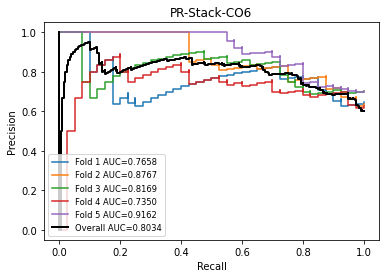

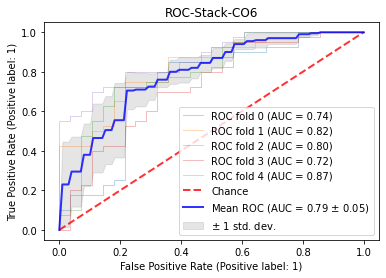

StackingClassifier(estimators=[('lr',
                                LogisticRegression(class_weight='balanced')),
                               ('ada', AdaBoostClassifier(learning_rate=0.1)),
                               ('bayes', GaussianNB())],
                   final_estimator=LogisticRegression())

In [44]:
# define the base models
level0 = list()
level0.append(('lr',LogisticRegression(class_weight='balanced') ))
# level0.append(('knn', KNeighborsClassifier()))
# level0.append(('gd', GradientBoostingClassifier()))
level0.append(('ada', AdaBoostClassifier(learning_rate=0.1,n_estimators=50)))
# level0.append(('rf', RandomForestClassifier(class_weight='balanced',n_estimators=500,random_state=1)))
level0.append(('bayes', GaussianNB()))

stackingClassifier_with_cross_validation(co6['X'],co6['Y'],level0,'CO6')